# Word2Vec: an introduction

Following: http://www.folgertkarsdorp.nl/word2vec-an-introduction/

Word2Vec (Mikolov et al, 2013) is a tool for learning continuous word embeddings from raw text. It associates words with points in space, and the spatial distance between words describes the similarity between them. Words are represented by continuous vectors over `x` dimensions.

In [1]:
import seaborn as sb
import numpy as np

/Users/perdue/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

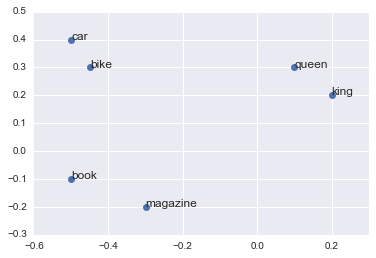

In [38]:
words = ['queen', 'book', 'king', 'magazine', 'car', 'bike']
vectors = np.array([[0.1, 0.3],
                   [-0.5, -0.1],
                   [0.2, 0.2],
                   [-0.3, -0.2],
                   [-0.5, 0.4],
                   [-0.45, 0.3]])
sb.plt.plot(vectors[:,0], vectors[:,1], 'o')
sb.plt.xlim(-0.6, 0.3)
sb.plt.ylim(-0.3, 0.5)
for word, x, y in zip(words, vectors[:,0], vectors[:,1]):
    sb.plt.annotate(word, (x, y), size=12)

The displacement vector describes the relationship between two words and we can often find analogies by looking for pairs of words with similar displacement vectors, e.g. `v[queen] - v[king] ~ v[woman] - v[man]`.

Word2vec learns continuous word embeddings by assuming the "distributional hypothesis". The means words may be characterized by words they are close to.

In [39]:
import pandas as pd

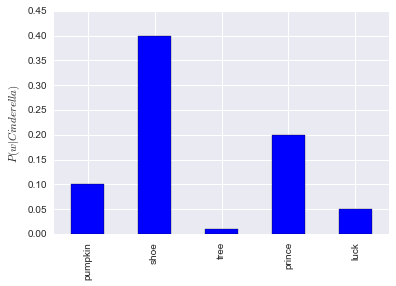

In [40]:
s = pd.Series([0.1, 0.4, 0.01, 0.2, 0.05],
             index=["pumpkin", "shoe", "tree", "prince", "luck"])
s.plot(kind='bar')
sb.plt.ylabel("$P(w|Cinderella)$")

## Softmax Regression

Word2Vec uses a neural network with one hidden layer.

<img src="http://www.folgertkarsdorp.nl/content/images/2015/01/neural-network.png">

The model considers each word along with a given context, e.g., $w_0$ = Cinderella, and $C$ = shoe. Given a context, can we predict $w_0$? This is mutlticlass classification with as many labels as our vocabulary size. We train by minimizing the cross entropy between the network output and the target distribution (as a one-hot vector) via stochastic gradient descent.

We have two weights matrices $W$ and $W'$ with dimensions $V \times N$ and $N \times V$ where $V$ is our vocabulary size and $N$ is the number of neurons in the hidden layer.

In [41]:
sentences = [
    'the king loves the queen',
    'the queen loves the king',
    'the dwarf hates the king',
    'the queen hates the dwarf',
    'the dwarf poisons the king',
    'the dwarf poisons the queen'
]

In [42]:
from collections import defaultdict

In [47]:
def Vocabulary():
    dictionary = defaultdict()
    dictionary.default_factory = lambda: len(dictionary)
    return dictionary

def docs2bow(docs, dictionary):
    """
    transform a list of strings into a list of lists with each unique item converted
    into a unique integer
    """
    # slicker way of doing this:
    # retd = []
    # for doc in docs:
    #     retd.append([dictionary[word] for word in doc.split()])
    # return retd
    for doc in docs:
        yield [dictionary[word] for word in doc.split()]

In [48]:
vocabulary = Vocabulary()
sentences_bow = list(docs2bow(sentences, vocabulary))

In [49]:
sentences_bow

[[0, 1, 2, 0, 3],
 [0, 3, 2, 0, 1],
 [0, 4, 5, 0, 1],
 [0, 3, 5, 0, 4],
 [0, 4, 6, 0, 1],
 [0, 4, 6, 0, 3]]

In [50]:
vocabulary

defaultdict(<function __main__.<lambda>>,
            {'dwarf': 4,
             'hates': 5,
             'king': 1,
             'loves': 2,
             'poisons': 6,
             'queen': 3,
             'the': 0})

We may now construct $W$ and $W'$:

In [51]:
V, N = len(vocabulary), 3
WI = (np.random.random((V, N)) - 0.5) / N
WO = (np.random.random((N, V)) - 0.5) / N

In [52]:
print np.shape(WI)
print np.shape(WO)

(7, 3)
(3, 7)


In [53]:
WI

array([[ 0.04880829,  0.0348627 ,  0.05100289],
       [ 0.15455296, -0.0596343 ,  0.13457032],
       [ 0.13506454, -0.10338932, -0.03087713],
       [-0.04674777,  0.06531993, -0.02223888],
       [-0.11350041,  0.16657378, -0.02967363],
       [-0.00422532,  0.04627318,  0.04734684],
       [-0.11001815, -0.11231455,  0.00104104]])

In [54]:
WO

array([[-0.05106556, -0.06946085, -0.11426283,  0.0185238 , -0.08800863,
        -0.15927485, -0.00493512],
       [ 0.03979307,  0.02218682, -0.00951367,  0.09445515, -0.13746232,
         0.05839972,  0.04797009],
       [-0.02125722,  0.11641793, -0.16251475, -0.1431275 , -0.04902283,
         0.16115979,  0.04901925]])

Each row $i$ in $W$ corresponds to a word $i$ and each column $j$ corresponds to the $j$th dimension ($j$th hidden neuron).

With these matrices we can compute the distance between an input word and the probability an output is a given value. For example, if the input is 'dwarf', what is the probability the output is 'hates'? The dot of the matrices gives us a "distance":

In [55]:
vocabulary['dwarf']

4

In [56]:
WI[vocabulary['dwarf']]

array([-0.11350041,  0.16657378, -0.02967363])

In [57]:
WO.T[vocabulary['hates']]

array([-0.15927485,  0.05839972,  0.16115979])

In [58]:
print np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary['hates']])

0.023023427134


In [59]:
for word in vocabulary.keys():
    print word, np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary[word]])

king 0.00812503447773
dwarf -0.0114539167903
queen 0.0178784060319
poisons 0.00709611776201
loves 0.016206551826
the 0.013055222774
hates 0.023023427134


Using a softmax function, we can trasnform these outputs into probabilities across our whole vocabulary:

\begin{equation}
P(w_O|w_I) = y_i = \frac{exp(W_I \cdot W_{O}^{'T})}{\sum_{j=1}^{V} exp(W_I \cdot W_{j}^{'T})}
\end{equation}

In [60]:
p = np.exp(-np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary['hates']])) / \
    sum(np.exp(-np.dot(WI[vocabulary['dwarf']], WO.T[vocabulary[w]])) for w in vocabulary)

In [61]:
print p

0.141080340286


In [62]:
1/7.

0.14285714285714285

## Updating the hidden-to-output layer weights

Word2Vec initially embeds words randomly, so we must learn better positions. We train by minimizing a loss function, $E = - \log P(w_O | w_I)$. Given the one-hot target distribution, $t$, the error may be computed as $t_j - y_j = e_j$, where $t_j$ is 1 iff $w_j$ is the actual output word.

To obtain the gradient on the hidden-to-output weights, we compute $e_j \cdot h_i$, where $h_i$ is a copy of the vector for the input word (this is true only with the context of a single word). Then we may use stochastic gradient descent with learning rate $\nu$ to obtain an update equation for the hidden-to-output weights:

\begin{equation}
W_{j}^{'T(t)} = W_{j}^{'T(t-1)} - \nu \cdot e_j \cdot h_j 
\end{equation}

In [63]:
target_word = 'king'
input_word = 'queen'
learning_rate = 1.0

for word in vocabulary:
    p_word_queen = (
        np.exp(-np.dot(WO.T[vocabulary[word]], WI[vocabulary[input_word]])) / 
            sum(np.exp(-np.dot(WO.T[vocabulary[w]], WI[vocabulary[input_word]])) for w in vocabulary)
    )
    t = 1 if word == target_word else 0
    error = t - p_word_queen
    print p_word_queen, word, t, error

0.143178962787 king 1 0.856821037213
0.144023620997 dwarf 0 -0.144023620997
0.142268463281 queen 0 -0.142268463281
0.143155111356 poisons 0 -0.143155111356
0.142290176102 loves 0 -0.142290176102
0.142699852972 the 0 -0.142699852972
0.142383812505 hates 0 -0.142383812505


In [64]:
target_word = 'king'
input_word = 'queen'
learning_rate = 1.0

for word in vocabulary:
    p_word_queen = (
        np.exp(-np.dot(WO.T[vocabulary[word]], WI[vocabulary[input_word]])) / 
            sum(np.exp(-np.dot(WO.T[vocabulary[w]], WI[vocabulary[input_word]])) for w in vocabulary)
    )
    t = 1 if word == target_word else 0
    error = t - p_word_queen
    print p_word_queen, word, t, error, WO.T[vocabulary[word]]
    WO.T[vocabulary[word]] = (
        WO.T[vocabulary[word]] - learning_rate * error * WI[vocabulary[input_word]]
    )
    print "new = ", WO.T[vocabulary[word]]
    
print WO.T

0.143178962787 king 1 0.856821037213 [-0.06946085  0.02218682  0.11641793]
new =  [-0.02940638 -0.03378066  0.13547268]
0.143900622925 dwarf 0 -0.143900622925 [-0.08800863 -0.13746232 -0.04902283]
new =  [-0.09473566 -0.12806274 -0.05222302]
0.142167404167 queen 0 -0.142167404167 [ 0.0185238   0.09445515 -0.1431275 ]
new =  [ 0.01187779  0.10374152 -0.14628915]
0.143073500308 poisons 0 -0.143073500308 [-0.00493512  0.04797009  0.04901925]
new =  [-0.01162348  0.05731564  0.04583745]
0.142229272726 loves 0 -0.142229272726 [-0.11426283 -0.00951367 -0.16251475]
new =  [-0.12091173 -0.00022327 -0.16567778]
0.142658811363 the 0 -0.142658811363 [-0.05106556  0.03979307 -0.02125722]
new =  [-0.05773454  0.04911153 -0.0244298 ]
0.142362978285 hates 0 -0.142362978285 [-0.15927485  0.05839972  0.16115979]
new =  [-0.16593001  0.06769886  0.1579938 ]
[[-0.05773454  0.04911153 -0.0244298 ]
 [-0.02940638 -0.03378066  0.13547268]
 [-0.12091173 -0.00022327 -0.16567778]
 [ 0.01187779  0.10374152 -0.14

## Updating the input-to-hidden layer weights

Next we must backpropagate the prediction erros to the input-to-hidden weights. We first compute $EH$, which is an $N$-dimensional vector representing the sum of the hidden-to-ouput vectors for each word in the vocabulary weighted by their prediction error:

\begin{equation}
\sum_{j=1}^V e_j \cdot W_{i,j}^{'} = EH_i
\end{equation}

Using the learning rate $\nu$ we update the weights with:

\begin{equation}
W_{w_I}^{(t)} = W_{w_I}^{(t-1)} - \nu \cdot EH 
\end{equation}

In [65]:
WI[vocabulary[input_word]] = WI[vocabulary[input_word]] - learning_rate * WO.sum(1)

Now we see the probability of 'king' given 'queen' has gone up:

In [66]:
for word in vocabulary:
    p = (np.exp(-np.dot(WO.T[vocabulary[word]],
                       WI[vocabulary[input_word]])) /
        sum(np.exp(-np.dot(WO.T[vocabulary[w]], 
                          WI[vocabulary[input_word]]))
           for w in vocabulary))
    print word, p

king 0.139678199757
dwarf 0.143626244061
queen 0.139282257027
poisons 0.1396120556
loves 0.146610401218
the 0.142565536037
hates 0.148625306301


## Multi-word context

The model described above is the CBOW architecture of Word2Vec. But, we assumed the context $C$ was only a single input word. This allowed us to simply copy the input vector to the hidden layer. But, if $C$ is multiple words, we take the mean of their input vectors as the hidden layer:

\begin{equation}
h = \frac{1}{C} (W_1 + W_2 + \cdots + W_C)
\end{equation}

The update function remains the same, when we update the input vectors, we need to apply the update to each word in the context:

\begin{equation}
W_{W_I}^{(t)} = W_{W_I}^{(t-1)} - \frac{1}{C} \cdot \nu \cdot EH 
\end{equation}

In [67]:
target_word = 'king'
context = ['queen', 'loves']

h = (WI[vocabulary['queen']] + WI[vocabulary['loves']]) / 2

In [68]:
h

array([ 0.27839039, -0.07693514, -0.0019001 ])

In [72]:
for word in vocabulary:
    p = (np.exp(-np.dot(WO.T[vocabulary[word]], h)) / 
        sum(np.exp(-np.dot(WO.T[vocabulary[w]], h))
           for w in vocabulary))
    t = 1 if word == target_word else 0
    error = t - p
    WO.T[vocabulary[word]] = (WO.T[vocabulary[word]] - learning_rate * error * h)
    
print WO

[[ 0.0209758  -0.50486658 -0.04127064  0.0890149  -0.01679696 -0.08455001
   0.06589258]
 [ 0.02735938  0.0976161  -0.02223264  0.08242413 -0.14960165  0.04520893
   0.03589353]
 [-0.02496702  0.13871783 -0.16622135 -0.14681563 -0.05275498  0.15743835
   0.04530838]]


In [73]:
for word in context:
    WI[vocabulary[word]] = (WI[vocabulary[word]] - (1. / len(context)) * learning_rate * WO.sum(1))

In [74]:
for word in vocabulary:
    p = (np.exp(-np.dot(WO.T[vocabulary[word]],
                       WI[vocabulary[input_word]])) /
        sum(np.exp(-np.dot(WO.T[vocabulary[w]], 
                          WI[vocabulary[input_word]]))
           for w in vocabulary))
    print word, p

king 0.208404597764
dwarf 0.131267873607
queen 0.125050505648
poisons 0.124825086282
loves 0.138242518981
the 0.130444038427
hates 0.141765379291
